In [1]:
import sys

sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, corot, starmodels
from astronn.utils import inferences
from astronn.utils.metrics import *
from astronn import models

import tensorflow as tf
tf.autograph.set_verbosity(0)
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Load stars datasets

In [2]:
# Read dataset with astroseismology info (dft, ac, hod, ...)
df_ds = deltascuti()
df_delta_scuti = df_ds.load(
    "../../astronn/data/deltascuti/preprocessed/*", batch_size=1
)

# Read csv with other phisical paramters (L, Teff, ..)
csv_delta_scuti = pd.read_csv("../data/deltascuti/binaries_obs.csv")
csv_delta_scuti

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,ID,Dnu_muHz,L,Teff,L.Ltot,parallax,mv,rho-gh17
0,KIC3858884,29,21.520774,6606,0.470,1.7800,9.3360,0.06570
1,KIC4544587,74,6.475306,7750,0.332,1.3600,10.8470,0.41400
2,KIC10661783,39,29.304625,7764,0.937,1.9400,9.5630,0.12550
3,HD172189,19,29.942319,7750,0.702,2.2700,8.8850,0.02830
4,CID100866999,56,3.865000,7300,NaN,0.5654,15.0970,0.26000
5,CID105906206,20,9.396579,6750,0.940,0.9901,12.2620,0.02986
6,HD159561,38,24.642612,8047,1.000,67.1300,2.1262,0.12400
7,KIC9851944,26,60.062351,6902,0.500,0.4100,11.4770,0.05660
8,KIC8262223,77,5.139949,9128,0.900,0.9832,12.8850,0.42300
9,KIC10080943,52,7.085301,7480,0.500,1.0600,11.7350,0.20500


In [3]:
# Read dataset with astroseismology info (dft, ac, hod, ...)
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

# Read csv with other phisical paramters (L, Teff, ..)
csv_bedding = pd.io.parsers.read_csv("../data/bedding/bedding_teff_logg_rad.csv", sep=",")
csv_bedding

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,HD,Name,TIC,V,Teff,L,e.L.,rho,e.rho.,Dnu,...,F0,logg,Teff_mast,e_logg,e_Teff_mast,stellar_radius,e_stellar_radius,L_mast,dnu_muhz,ID
0,2280.0,NaN,281499618,9.13,7510.0,5.52,0.26,0.49,0.06,7.17,...,19.5741,4.39426,7575.00,0.079169,138.757,1.39528,0.042407,5.774924,82.986111,TESS2018234235059-S0002-0000000281499618-0121-...
1,3622.0,NaN,43363194,7.77,7930.0,7.86,0.35,0.45,0.06,6.89,...,17.9829,4.33815,7779.00,0.080995,127.816,1.52225,0.043553,7.644720,79.745370,TESS2018263035959-S0003-0000000043363194-0123-...
2,10779.0,NaN,229139161,8.78,7730.0,8.13,0.36,0.39,0.05,6.80,...,17.8840,4.31312,7862.00,0.079127,143.816,1.57905,0.044208,8.582641,78.703704,TESS2018234235059-S0002-0000000229139161-0121-...
3,10961.0,NaN,231014033,9.39,7430.0,NaN,NaN,NaN,NaN,7.30,...,19.7100,4.30846,7600.00,0.080017,137.430,1.54452,0.052922,7.170244,84.490741,TESS2018263035959-S0003-0000000231014033-0123-...
4,17341.0,NaN,122615966,9.32,7810.0,10.05,0.50,0.32,0.05,5.90,...,16.1070,4.24043,7850.00,0.078290,131.083,1.71688,0.046400,10.084488,68.287037,TESS2018263035959-S0003-0000000122615966-0123-...
5,17693.0,NaN,122686610,7.80,7880.0,10.21,0.44,0.33,0.04,6.41,...,16.7301,4.24711,7940.00,0.074653,132.040,1.72004,0.047045,10.593836,74.189815,TESS2018263035959-S0003-0000000122686610-0123-...
6,20203.0,NaN,274038922,8.85,7970.0,8.06,0.38,0.45,0.05,7.20,...,19.8720,4.39860,8144.00,0.073741,167.493,1.47477,0.046296,8.619781,83.333333,TESS2018292075959-S0004-0000000274038922-0124-...
7,20232.0,NaN,159895674,6.88,8060.0,8.64,0.36,0.44,0.05,6.86,...,18.1104,4.33075,7963.00,0.072418,128.366,1.56787,0.043286,8.904756,79.398148,TESS2018263035959-S0003-0000000159895674-0123-...
8,24572.0,NaN,242944780,9.45,7410.0,7.25,0.36,0.35,0.05,7.20,...,18.5760,4.32415,7928.00,0.087546,473.676,1.57199,0.052960,8.795318,83.333333,TESS2018319095959-S0005-0000000242944780-0125-...
9,24975.0,NaN,44645679,7.24,7790.0,9.20,0.39,0.35,0.04,6.23,...,16.0734,4.23611,7693.00,0.077129,119.353,1.69752,0.047540,9.093042,72.106481,TESS2018319095959-S0005-0000000044645679-0125-...


### Load pretrainned NN model

In [4]:
sepconv_mod = tf.keras.models.load_model(
    "/home/roberto/Projects/best_train/sepconvnn_tmp_dos_200/"
)
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 351, 10)           1010      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 342, 10)           1010      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 68, 10)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 68, 10)            40        
_________________________________________________________________
flatten (Flatten)            (None, 680)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               68100     
Total params: 70,160
Trainable params: 70,140
Non-trainable params: 20
___________________________________________________

### Load $\rho$ Roche models

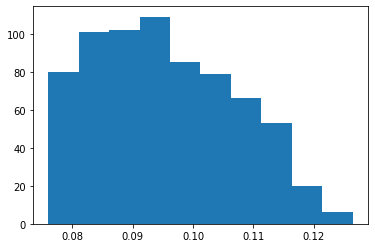

In [5]:
models = pd.read_csv(
    "/home/roberto/Downloads/evolutionTracks_line_rho_roche/models_params.csv",
    header=None,
    names=["Teff", "Dnu", "L_must", "rho_roche"],
)


def get_avg_rho_roche(teff, l, e_teff=300, e_l=1):
    """
    Get rho from Roche models by constrainning star models based
    on L and Teff. If there is not rsults, an adaptative search
    is performed
    """
    id_teff = models["Teff"].between(teff - e_teff, teff + e_teff, inclusive=True)
    id_l = models["L_must"].between(l - e_l, l + e_l, inclusive=True)
    max_adaptative_iters = 1
    iters_count = 0
    while len(models[(id_teff & id_l)]) == 0 and iters_count < max_adaptative_iters :
        e_teff += 300
        id_teff = models["Teff"].between(teff - e_teff, teff + e_teff, inclusive=True)
        iters_count += 1
        print(" ***warning, adaptative step performed on star models rho Roche search")
    return models[(id_teff & id_l)]["rho_roche"]

plt.hist(get_avg_rho_roche(8920.860521, 60))
plt.show()

In [6]:
models.head()

,Teff,Dnu,L_must,rho_roche
0,9320.860521,2.922405,66.949234,0.110034
1,10157.683269,4.124967,58.663354,0.225869
2,9607.163384,3.228179,64.706039,0.138940
3,10372.144985,4.588722,55.802210,0.276591
4,9494.226367,3.141663,65.651536,0.126560


## Results for 11 Binary DS Stars

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


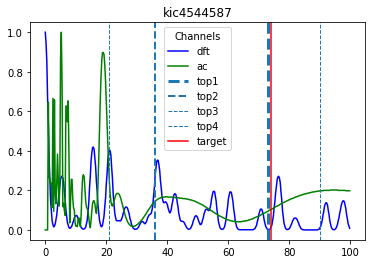

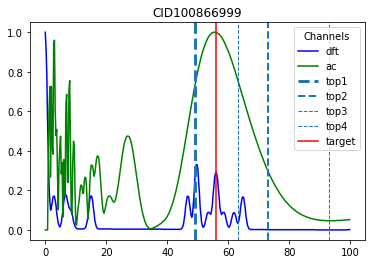

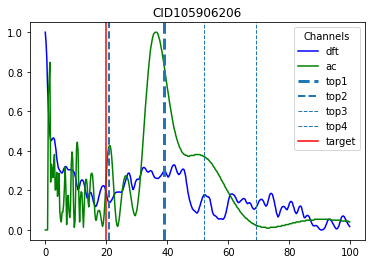

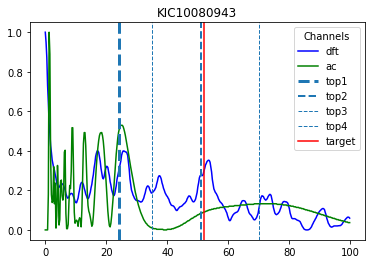

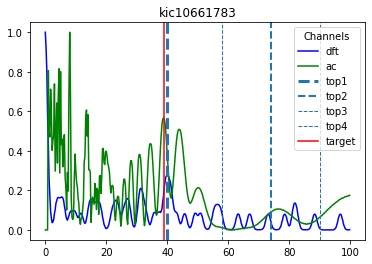

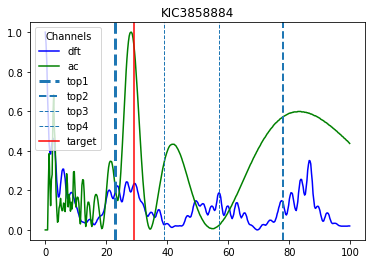

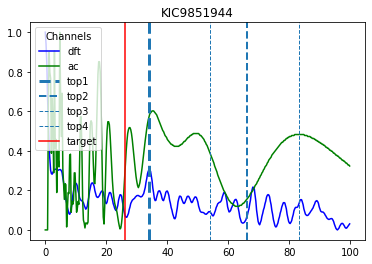

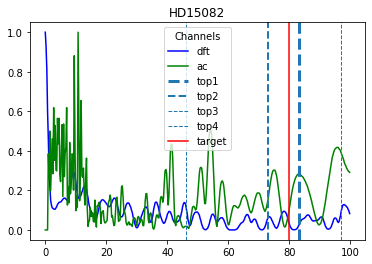

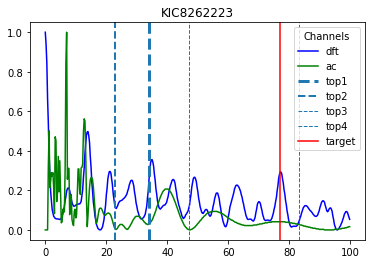

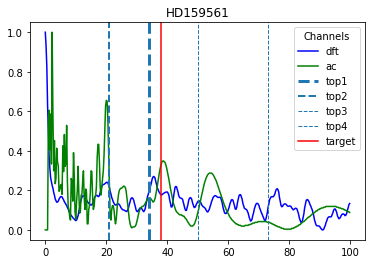

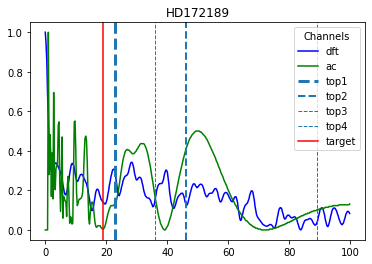

In [7]:
inf = inferences()
df_results_delta_scuti = inf.get_processed_inferences(
    nn_model=sepconv_mod,
    df_stars=df_delta_scuti,
    take_number=11,
    csv_L=csv_delta_scuti,
    debug=True,
)
df_results_delta_scuti.id = df_results_delta_scuti.id.str.upper()

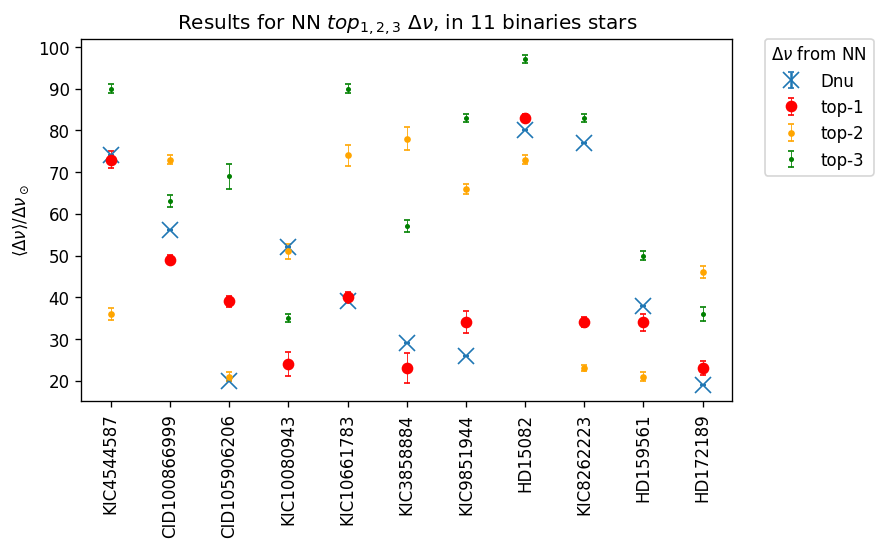

In [8]:
inf.plot_inferences(
    df_results_delta_scuti,
    plot_title="Results for NN $top_{1,2,3}$ $\Delta\\nu$, in 11 binaries stars",
    plot_size=(7, 4),
)

In [9]:
df_results_delta_scuti_merged = df_results_delta_scuti.merge(csv_delta_scuti , left_on="id", right_on="ID", how="left").drop('ID', 1)
df_results_delta_scuti_merged

,id,dnu-target,top1,e-top1,top2,e-top2,top3,e-top3,top4,e-top4,...,e-rho-top3,rho-top4,e-rho-top4,Dnu_muHz,L,Teff,L.Ltot,parallax,mv,rho-gh17
0,KIC4544587,74,73,1.929718,36,1.490254,90,1.030482,21,1.116072,...,0.221437,0.0374136,0.012076,74,6.475306,7750,0.332,1.3600,10.8470,0.41400
1,CID100866999,56,49,1.044763,73,1.029168,63,1.455164,93,0.980278,...,0.108163,0.755931,0.236542,56,3.865000,7300,NaN,0.5654,15.0970,0.26000
2,CID105906206,20,39,1.229034,21,1.178451,69,2.962202,52,1.141167,...,0.129821,0.2336,0.073637,20,9.396579,6750,0.940,0.9901,12.2620,0.02986
3,KIC10080943,52,24,2.963901,51,1.824679,35,0.926366,70,1.046125,...,0.033382,0.425838,0.133625,52,7.085301,7480,0.500,1.0600,11.7350,0.20500
4,KIC10661783,39,40,1.297765,74,2.518126,90,1.087349,58,1.154284,...,0.221437,0.291253,0.091640,39,29.304625,7764,0.937,1.9400,9.5630,0.12550
5,KIC3858884,29,23,3.613644,78,2.693781,57,1.409748,39,1.314869,...,0.088501,0.130646,0.041429,29,21.520774,6606,0.470,1.7800,9.3360,0.06570
6,KIC9851944,26,34,2.605530,66,1.189474,83,1.003733,54,1.387807,...,0.188156,0.252105,0.079417,26,60.062351,6902,0.500,0.4100,11.4770,0.05660
7,HD15082,80,83,1.011470,73,1.015208,97,0.954947,46,1.144795,...,0.257471,0.182355,0.057618,80,6.140000,7430,0.000,0.0000,0.0000,0.50700
8,KIC8262223,77,34,1.161095,23,0.757434,83,1.005299,47,1.311323,...,0.188156,0.190451,0.060151,77,5.139949,9128,0.900,0.9832,12.8850,0.42300
9,HD159561,38,34,2.024747,21,1.064188,50,1.013231,73,1.730440,...,0.068077,0.463509,0.145372,38,24.642612,8047,1.000,67.1300,2.1262,0.12400


#### Select the closest $\text{top}_1$ or $\text{top}_2$ to the RM relation

In [10]:
def check_dnu_in_RM_relation(dnu, rho):
    """
    """
    # Get rho with upper and lower limits
    rs = get_rho(dnu / dnu_sun)
    rs_upper = get_rho_upper_bound(dnu / dnu_sun)
    rs_lower = get_rho_lower_bound(dnu / dnu_sun)

    # Check if proposed rho is inside bands
    if rho >= rs_lower and rho <= rs_upper:
        return True
    else:
        return False


df_results_delta_scuti_merged[["top1", "rho-gh17"]].apply(
    lambda x: check_dnu_in_RM_relation(x["top1"], x["rho-gh17"]), axis=1
)

0      True
1      True
2     False
3     False
4      True
5     False
6     False
7      True
8     False
9      True
10    False
dtype: bool

In [11]:
# Select best from top1, top1/2 or top1*2
select_closest_top = np.argmin(
    (
        np.power(
            get_dnu_from_rho(df_results_delta_scuti_merged["rho-gh17"]) / 0.0864
            - df_results_delta_scuti_merged["top1"] * 0.0864,
            2,
        ),
        np.power(
            get_dnu_from_rho(df_results_delta_scuti_merged["rho-gh17"]) / 0.0864
            - df_results_delta_scuti_merged["top1"] * 1/2 * 0.0864,
            2,
        ),
        np.power(
            get_dnu_from_rho(df_results_delta_scuti_merged["rho-gh17"]) / 0.0864
            - df_results_delta_scuti_merged["top1"] * 2 * 0.0864,
            2,
        )
    ),
    axis=0,
)


tops = np.where(
    select_closest_top == 0,
    df_results_delta_scuti_merged["top1"],
    np.where(
        select_closest_top == 1,
        df_results_delta_scuti_merged["top1"] * 1/2,
        df_results_delta_scuti_merged["top1"] * 2,
    ),
)
# Show multiples
tops

array([73, 49, 19.5, 48, 40, 23, 34, 83, 68, 34, 23], dtype=object)

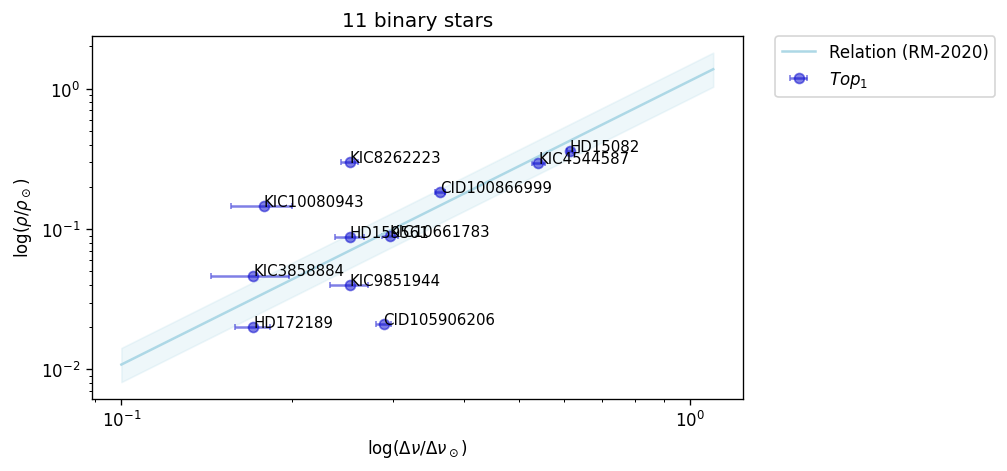

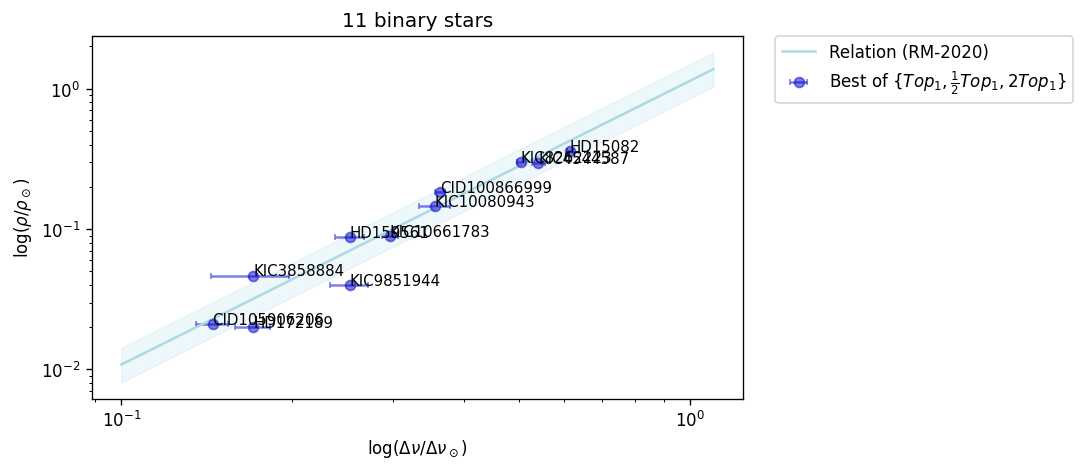

In [12]:
inferences.plot_relation_rodriguez(
    dnus=df_results_delta_scuti_merged["top1"].values.astype(float),
    rhos=df_results_delta_scuti_merged["rho-gh17"].values.astype(float),
    ednus=df_results_delta_scuti_merged["e-top1"].values.astype(float),
    points_ids=df_results_delta_scuti_merged["id"],
    plot_title="11 binary stars",
    points_label="$Top_1$",
)

inferences.plot_relation_rodriguez(
    dnus=tops.astype(float),
    rhos=df_results_delta_scuti_merged["rho-gh17"].values.astype(float),
    ednus=df_results_delta_scuti_merged["e-top1"].values.astype(float),
    points_ids=df_results_delta_scuti_merged["id"],
    plot_title="11 binary stars",
    points_label="Best of $\{Top_{1}, \\frac{1}{2}Top_{1}, 2Top_{1} \}$",
)

## Results for 57 Bedding stars


In [13]:
df_results_bedding = inf.get_processed_inferences(
    nn_model=sepconv_mod,
    df_stars=df_bedding,
    take_number=57,
    csv_L=csv_bedding,
    debug=False,
)

In [14]:
df_results_bedding["TIC"] = df_results_bedding["id"].str.split("-").str[2].astype(int)
df_bedding_att = pd.io.parsers.read_csv(
    "../data/bedding/bedding_teff_logg_rad.csv", sep=",", index_col=0
)
df_bedding_att
df_bedding_att = df_bedding_att.head(57)
df_bedding_att["TIC"] = df_bedding_att["TIC"].astype(int)

# Merge
df_results_bedding_merged = df_results_bedding.merge(
    df_bedding_att, left_on="TIC", right_on="TIC", how="left"
)

# Replace L and Teff Bedding values, for MAST values when NaN
df_results_bedding_merged.L.fillna(df_results_bedding_merged.L_mast, inplace=True)
df_results_bedding_merged.Teff.fillna(df_results_bedding_merged.Teff_mast, inplace=True)
df_results_bedding_merged

,id,dnu-target,top1,e-top1,top2,e-top2,top3,e-top3,top4,e-top4,...,F0,logg,Teff_mast,e_logg,e_Teff_mast,stellar_radius,e_stellar_radius,L_mast,dnu_muhz,ID
0,tess2019032160000-s0008-0000000176400189-0136-...,76,32,1.466002,71,1.159129,52,1.154854,21,1.109137,...,17.1312,3.92691,7202.00,0.091352,142.357,2.28769,0.119186,12.685331,76.851852,TESS2019032160000-S0008-0000000176400189-0136-...
1,tess2018349182459-s0006-0000000011361473-0126-...,87,44,1.014310,56,1.178350,75,1.373552,90,1.783472,...,20.0075,4.47037,9692.00,0.085830,732.909,1.51486,0.065254,18.242876,87.384259,TESS2018349182459-S0006-0000000011361473-0126-...
2,tess2018319095959-s0005-0000000349645354-0125-...,61,27,1.230694,60,1.614049,38,0.957913,95,1.052234,...,14.3646,4.11525,7401.00,0.084291,140.628,1.88518,0.068065,9.606420,61.805556,TESS2018319095959-S0005-0000000349645354-0125-...
3,tess2019169103026-s0013-0000000269792989-0146-...,78,71,1.262247,31,1.067596,54,1.074314,20,1.462074,...,18.8046,4.28198,7888.00,0.076845,143.779,1.64542,0.046400,9.443132,78.009259,TESS2019169103026-S0013-0000000269792989-0146-...
4,tess2018319095959-s0005-0000000100531058-0125-...,79,38,1.314322,22,1.048925,77,1.207267,62,2.709723,...,18.4920,4.41043,8710.00,0.067716,145.327,1.52527,0.042106,12.063099,79.861111,TESS2018319095959-S0005-0000000100531058-0125-...
5,tess2018263035959-s0003-0000000150272131-0123-...,83,40,1.021932,79,1.254240,65,2.107169,54,1.198524,...,19.5750,4.18186,7421.98,0.081793,115.665,1.75116,0.064183,8.383549,83.912037,TESS2018263035959-S0003-0000000150272131-0123-...
6,tess2018349182459-s0006-0000000282265535-0126-...,80,75,1.690436,36,1.485896,98,0.963055,52,1.322385,...,18.2785,4.31587,7756.00,0.076316,132.995,1.55797,0.045980,7.913453,80.439815,TESS2018349182459-S0006-0000000282265535-0126-...
7,tess2019058134432-s0009-0000000260161111-0139-...,84,80,1.068493,66,1.199105,42,1.210094,29,1.138069,...,NaN,4.39985,8149.00,0.074992,143.032,1.47413,0.052711,8.633460,84.143519,TESS2019058134432-S0009-0000000260161111-0139-...
8,tess2018234235059-s0002-0000000327996759-0121-...,69,42,1.149749,90,1.459779,71,2.637805,56,1.075839,...,17.0328,NaN,7527.00,NaN,NaN,2.53666,NaN,NaN,69.907407,TESS2018234235059-S0002-0000000327996759-0121-...
9,tess2018319095959-s0005-0000000316920092-0125-...,80,35,1.220290,69,1.579554,96,1.060360,54,2.088074,...,17.8432,4.32069,7869.00,0.077561,144.656,1.56870,0.043286,8.500613,80.671296,TESS2018319095959-S0005-0000000316920092-0125-...


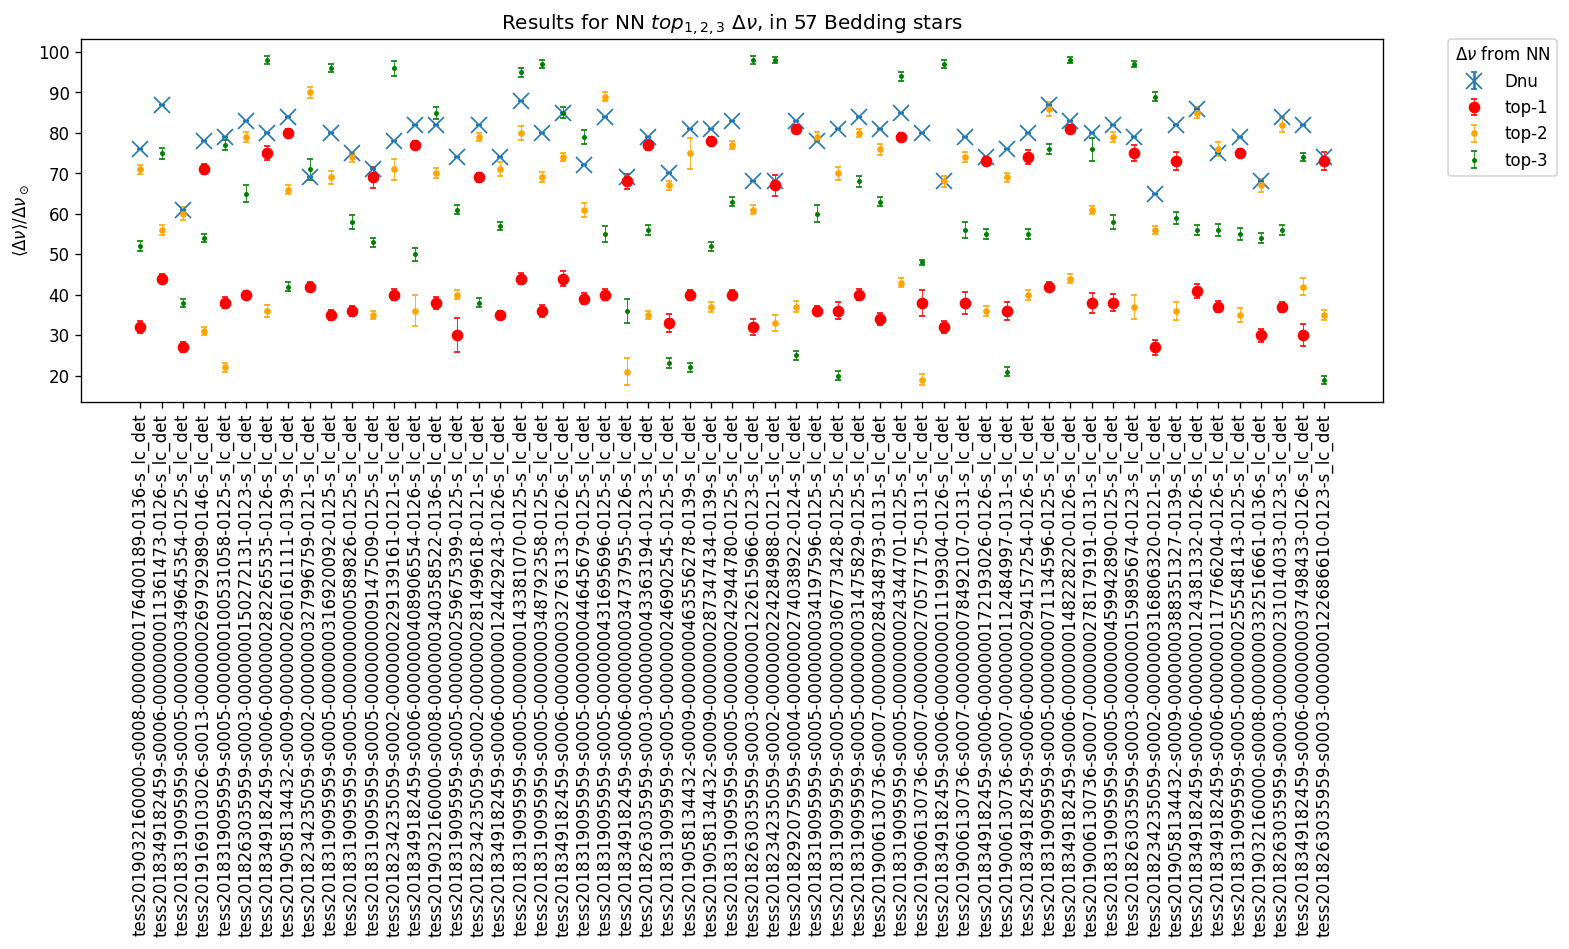

In [15]:
inf.plot_inferences(
    df_results_bedding_merged,
    plot_title="Results for NN $top_{1,2,3}$ $\Delta\\nu$, in 57 Bedding stars",
    plot_size=(14, 4),
)

In [16]:
df_results_bedding_merged["avg_rho_roche"] = df_results_bedding_merged[
    ["Teff", "L"]
].apply(lambda x: np.average(get_avg_rho_roche(x["Teff"], x["L"])), axis=1)
df_results_bedding_merged

 ***warning, adaptative step performed on star models rho Roche search
 ***warning, adaptative step performed on star models rho Roche search
 ***warning, adaptative step performed on star models rho Roche search


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,id,dnu-target,top1,e-top1,top2,e-top2,top3,e-top3,top4,e-top4,...,logg,Teff_mast,e_logg,e_Teff_mast,stellar_radius,e_stellar_radius,L_mast,dnu_muhz,ID,avg_rho_roche
0,tess2019032160000-s0008-0000000176400189-0136-...,76,32,1.466002,71,1.159129,52,1.154854,21,1.109137,...,3.92691,7202.00,0.091352,142.357,2.28769,0.119186,12.685331,76.851852,TESS2019032160000-S0008-0000000176400189-0136-...,0.200010
1,tess2018349182459-s0006-0000000011361473-0126-...,87,44,1.014310,56,1.178350,75,1.373552,90,1.783472,...,4.47037,9692.00,0.085830,732.909,1.51486,0.065254,18.242876,87.384259,TESS2018349182459-S0006-0000000011361473-0126-...,0.509525
2,tess2018319095959-s0005-0000000349645354-0125-...,61,27,1.230694,60,1.614049,38,0.957913,95,1.052234,...,4.11525,7401.00,0.084291,140.628,1.88518,0.068065,9.606420,61.805556,TESS2018319095959-S0005-0000000349645354-0125-...,0.339872
3,tess2019169103026-s0013-0000000269792989-0146-...,78,71,1.262247,31,1.067596,54,1.074314,20,1.462074,...,4.28198,7888.00,0.076845,143.779,1.64542,0.046400,9.443132,78.009259,TESS2019169103026-S0013-0000000269792989-0146-...,0.484208
4,tess2018319095959-s0005-0000000100531058-0125-...,79,38,1.314322,22,1.048925,77,1.207267,62,2.709723,...,4.41043,8710.00,0.067716,145.327,1.52527,0.042106,12.063099,79.861111,TESS2018319095959-S0005-0000000100531058-0125-...,0.535901
5,tess2018263035959-s0003-0000000150272131-0123-...,83,40,1.021932,79,1.254240,65,2.107169,54,1.198524,...,4.18186,7421.98,0.081793,115.665,1.75116,0.064183,8.383549,83.912037,TESS2018263035959-S0003-0000000150272131-0123-...,0.531363
6,tess2018349182459-s0006-0000000282265535-0126-...,80,75,1.690436,36,1.485896,98,0.963055,52,1.322385,...,4.31587,7756.00,0.076316,132.995,1.55797,0.045980,7.913453,80.439815,TESS2018349182459-S0006-0000000282265535-0126-...,0.526345
7,tess2019058134432-s0009-0000000260161111-0139-...,84,80,1.068493,66,1.199105,42,1.210094,29,1.138069,...,4.39985,8149.00,0.074992,143.032,1.47413,0.052711,8.633460,84.143519,TESS2019058134432-S0009-0000000260161111-0139-...,0.564978
8,tess2018234235059-s0002-0000000327996759-0121-...,69,42,1.149749,90,1.459779,71,2.637805,56,1.075839,...,NaN,7527.00,NaN,NaN,2.53666,NaN,NaN,69.907407,TESS2018234235059-S0002-0000000327996759-0121-...,NaN
9,tess2018319095959-s0005-0000000316920092-0125-...,80,35,1.220290,69,1.579554,96,1.060360,54,2.088074,...,4.32069,7869.00,0.077561,144.656,1.56870,0.043286,8.500613,80.671296,TESS2018319095959-S0005-0000000316920092-0125-...,0.518466


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


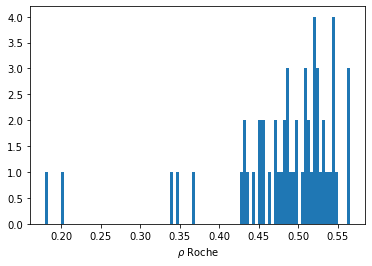

In [17]:
plt.hist(df_results_bedding_merged["avg_rho_roche"], bins=100)
plt.xlabel("$\\rho$ Roche")
plt.show()

In [18]:
# Select best from top1, top1/2 or top1*2
select_closest_top = np.argmin(
    (
        np.power(
            get_dnu_from_rho(df_results_bedding_merged["avg_rho_roche"]) / 0.0864
            - df_results_bedding_merged["top1"] * 0.0864,
            2,
        ),
        np.power(
            get_dnu_from_rho(df_results_bedding_merged["avg_rho_roche"]) / 0.0864
            - df_results_bedding_merged["top1"] * 1/2 * 0.0864,
            2,
        ),
        np.power(
            get_dnu_from_rho(df_results_bedding_merged["avg_rho_roche"]) / 0.0864
            - df_results_bedding_merged["top1"] * 2 * 0.0864,
            2,
        )
    ),
    axis=0,
)


tops = np.where(
    select_closest_top == 0,
    df_results_bedding_merged["top1"],
    np.where(
        select_closest_top == 1,
        df_results_bedding_merged["top1"] / 2,
        df_results_bedding_merged["top1"] * 2,
    ),
)
# Show multiples
tops

array([32, 88, 54, 71, 76, 80, 75, 80, 42, 70, 72, 69, 80, 77, 76, 60, 69,
       70, 88, 72, 88, 78, 80, 68, 77, 66, 40, 78, 80, 64, 67, 81, 72, 72,
       80, 68, 79, 76, 64, 76, 73, 72, 74, 84, 81, 76, 38, 75, 54, 73, 82,
       74, 75, 60, 74, 60, 73], dtype=object)

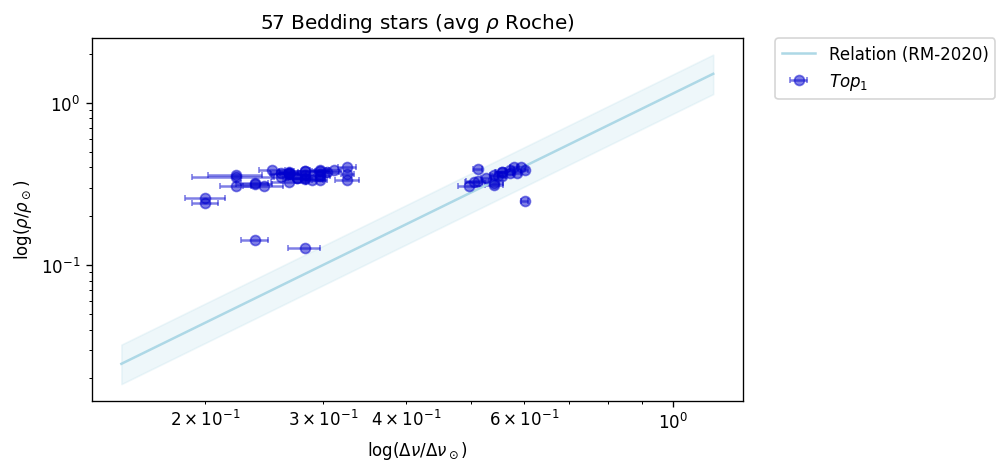

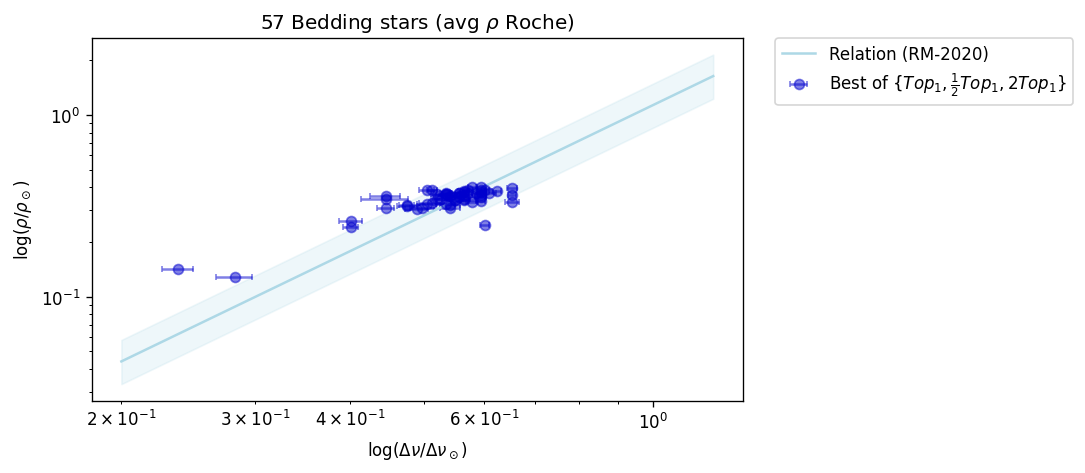

In [21]:
inferences.plot_relation_rodriguez(
    dnus=df_results_bedding_merged["top1"].values.astype(float),
    rhos=df_results_bedding_merged["avg_rho_roche"].values.astype(float),
    ednus=df_results_bedding_merged["e-top1"].values.astype(float),
    points_ids=None,
    plot_title="57 Bedding stars (avg $\\rho$ Roche)",
    points_label="$Top_1$",
    relation_line_range=(0.15, 1.3),
)

inferences.plot_relation_rodriguez(
    dnus=tops.astype(float),
    rhos=df_results_bedding_merged["avg_rho_roche"].values.astype(float),
    ednus=df_results_bedding_merged["e-top1"].values.astype(float),
    points_ids=None,
    plot_title="57 Bedding stars (avg $\\rho$ Roche)",
    points_label="Best of $\{Top_{1}, \\frac{1}{2}Top_{1}, 2Top_{1} \}$",
    relation_line_range=(0.2, 1.3),
)

### Histogram of $\rho$ Roche distributions for every single star (57 Bedding stars)

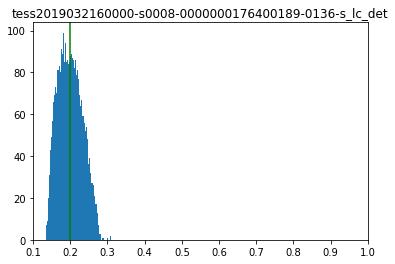

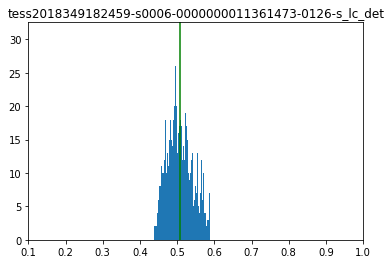

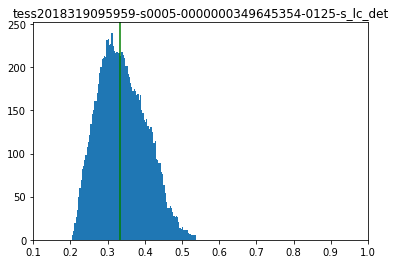

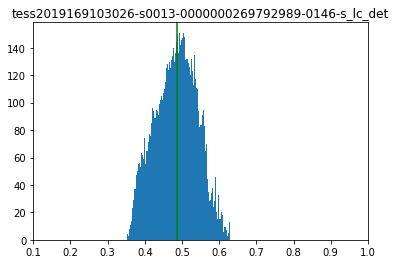

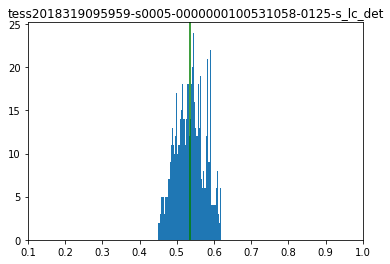

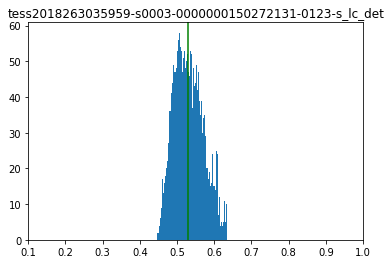

 ***warning, adaptative step performed on star models rho Roche search
 ***warning, adaptative step performed on star models rho Roche search


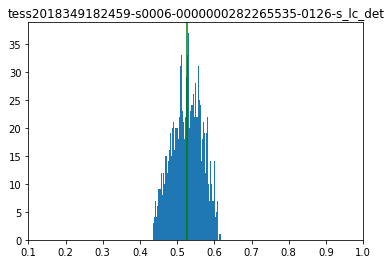

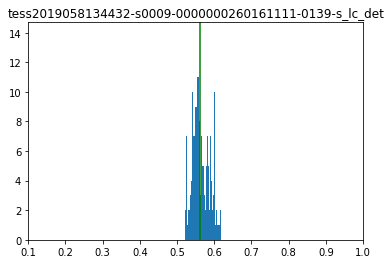

 ***warning, adaptative step performed on star models rho Roche search
 ***warning, adaptative step performed on star models rho Roche search


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


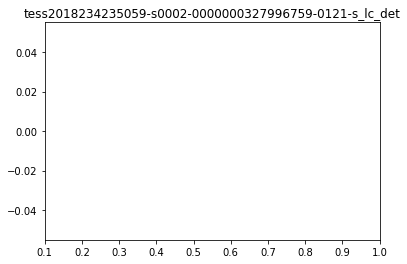

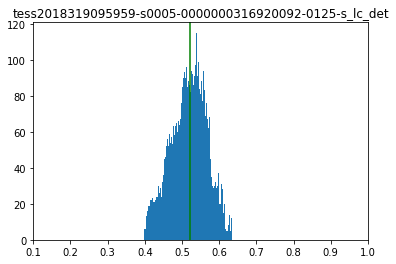

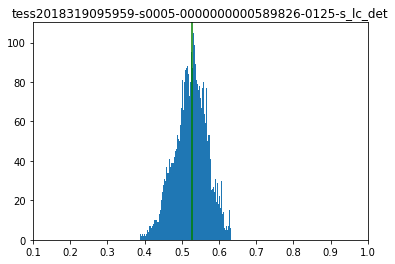

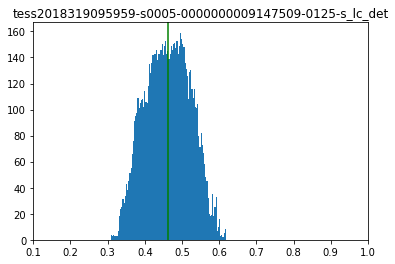

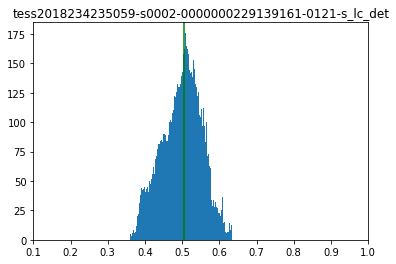

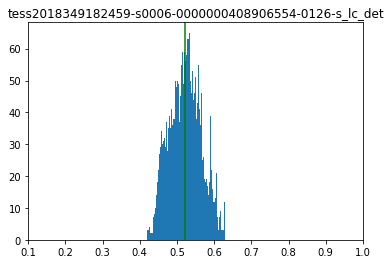

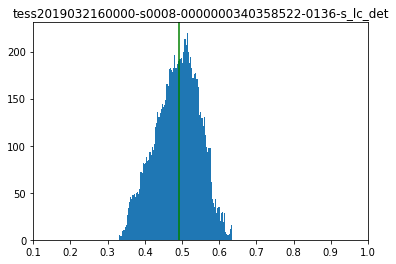

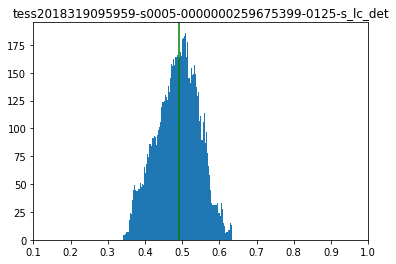

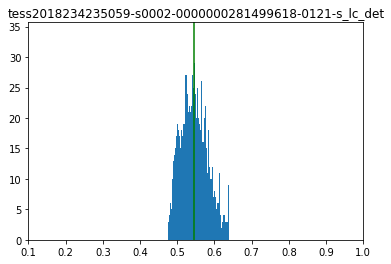

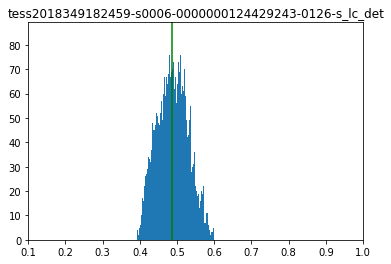

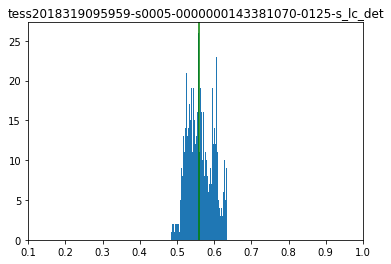

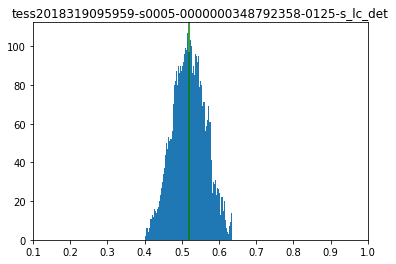

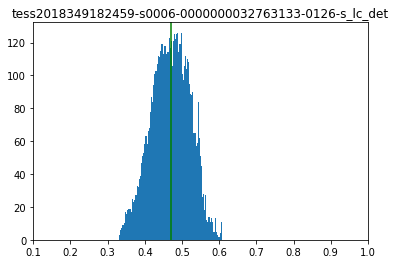

In [20]:
for i, row in df_results_bedding_merged.iterrows():
    avg_rho_roche = np.median(get_avg_rho_roche(row["Teff"], row["L"]))
    plt.hist(get_avg_rho_roche(row["Teff"], row["L"]), bins=100)
    plt.axvline(x=avg_rho_roche, color="green")
    plt.title(row["id"])
    plt.xlim(0.1, 1.0)
    plt.show()
    if i == 20:
        break